# MNIST Handwritten Digit Recognition in PyTorch

Zhaohua Tian
2021 07 10

在这个例子中学习用Pytorch建模进行数字识别。手写字体识别一个最简单的例子，有了这个的搭建经验之后，其他的识别就可以非常轻松胜任。
我是照着这个教程一步步来的
https://nextjournal.com/gkoehler/pytorch-mnist

## 准备数据

首先是插入必要的包

In [5]:
import torch
import torchvision

准备好准备数据库

In [64]:
n_epochs = 3 # 打算训练几个周期
batch_size_train = 64 # 用训练的样本个数
batch_size_test = 1000 # 用来测试的样本个数
learning_rate = 0.01 # 学习速率
momentum = 0.5 # 顾名思义就是动量，可以参见这篇博文，https://blog.csdn.net/weixin_40793406/article/details/84666803
log_interval = 10 # 每训练几个数据输出一个训练结果到屏幕

random_seed = 1
torch.backends.cudnn.enabled = False #没有cuda
torch.manual_seed(random_seed) #让结果具有重复性，设置随机固定，可以参见，https://blog.csdn.net/weixin_43002433/article/details/104706950

然后是准备数据,需要从`torchvision`里面调用

In [79]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,#训练过的数据，需要下载
                             transform=torchvision.transforms.Compose([ #以用compose将这些图像预处理操作连起来。
                               torchvision.transforms.ToTensor(), # 将一个PIL图像转换为tensor。即，(H*W*C)范围在[0,255]的PIL图像 转换为 (C*H*W)范围在[0,1]的torch.tensor。
                               torchvision.transforms.Normalize( # 归一化设置均值和标准差
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)#每次都重新洗牌

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,#没训练过的数据，需要下载
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

我们可以查看下载下来的数据长什么样子

In [80]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [81]:
example_data.shape

torch.Size([1000, 1, 28, 28])

我们可以尝试访问里面的数据

C:\Users\xiail\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


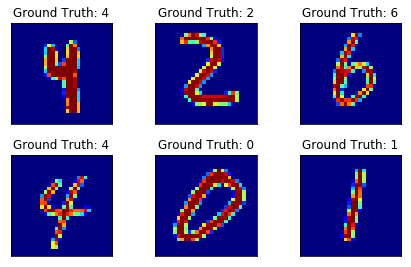

In [83]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='jet', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

## 搭建神经网络

In [2]:
import torch.nn as nn
import torch.nn.functional as F #一些层的设置通过这个函数实现，比如卷积层
import torch.optim as optim #优化函数，必须得有的

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #标准化流程
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #第一层卷积层
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# 第二层卷积层
        self.conv2_drop = nn.Dropout2d()# 第三层将负数去掉
        self.fc1 = nn.Linear(320, 50) #第四层线性层
        self.fc2 = nn.Linear(50, 10)# 最后一层线性层

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))# 先卷积层再进行池化操作，取最大值
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))# 先卷积再进行池化操作，取最大值
        x = x.view(-1, 320)# 转化为一维向量
        x = F.relu(self.fc1(x))# 线性操作之后在去掉负数
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

* 池化层的操作是为了减小体积，也需要设置
* Dropout是为了防止或减轻过拟合而使用的函数，它一般用在全连接层。
* Dropout 是训练过程中，对于神经网络单元，按照一定的概率将其暂时从网络中丢弃。注意是暂时，对于随机梯度下降来说，由于是随机丢弃，故而每一个mini-batch都在训练不同的网络。
* 池化操作:
    输入: (N,C,H_{in},W_in)
    输出: (N,C,H_out,W_out)
$$H_{out}=floor((H_{in} + 2padding[0] - dilation[0](kernel\_size[0] - 1) - 1)/stride[0] + 1$$

$$W_{out}=floor((W_{in} + 2padding[1] - dilation[1](kernel\_size[1] - 1) - 1)/stride[1] + 1$$

我们的神经网络层的几何形状变化为：
1. 原始为$1000\times1\times28\times28$
2. 第一个卷积层以后变成$1000\times1\times(28-5+1)\times(28-5+1)\times 10$=$1000\times1\times(24)\times(24)\times 10$
3. 第一个卷积层以后池化最大操作变成$1000\times1\times(24/2)\times(24/2)\times 10$=$1000\times1\times(12)\times(12)\times 10$
4. 第二个卷积层以后变成$1000\times1\times(12-5+1)\times(12-5+1)\times 20$=$1000\times1\times(8)\times(8)\times 20$
5. 第二个卷积层以后池化最大操作变成$1000\times1\times(8/2)\times(8/2)\times 20$=$1000\times1\times(4)\times(4)\times 20$
6. 最后编程一维的数据$1000\times1\times 320$
下面有一个更加简洁的例子来打印这些形状变化

In [8]:
m1=nn.Conv2d(1, 10, kernel_size=5)
m2=nn.Conv2d(10, 20, kernel_size=5)
a=torch.randn(100, 1, 28, 28)
b=m1(a)
c=F.max_pool2d(b,2)
d=m2(c)
e=F.max_pool2d(d,2)
print(a.shape,b.shape,c.shape,d.shape,e.shape)
f=e.view(-1, 320)# -1的意思就是让它自己运算
print(f.shape)
g=f.view(1,1,100,320)
print(g.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100, 10, 24, 24]) torch.Size([100, 10, 12, 12]) torch.Size([100, 20, 8, 8]) torch.Size([100, 20, 4, 4])
torch.Size([100, 320])
torch.Size([1, 1, 100, 320])


In [139]:
network = Net()# 舒适化对象
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum) # 初始化优化器

## 训练模型

一切准备就绪之后，就可以来训练我们的模型了，首先需要初始化一些容器

In [140]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
print(test_counter)

[0, 60000, 120000, 180000]


In [141]:
def train(epoch):
  network.train()# 训练开始
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()# 求解初始化矩阵的梯度
    output = network(data)# 计算初始化矩阵的输出
    loss = F.nll_loss(output, target)#计算误差
    loss.backward()#根据误差计算梯度
    optimizer.step()#更新参数
    # 然后每隔一段时间就输出一下训练进度
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

另外我们还需要一个测试函数，每结果一轮训练，我们就用测试函数来测试准确率，基础测试的时候我们不会进行训练

In [142]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)#计算输出
      test_loss += F.nll_loss(output, target, size_average=False).item()#累加误差
      pred = output.data.max(1, keepdim=True)[1]#求输出最大值作为结果
      correct += pred.eq(target.data.view_as(pred)).sum()# 统计结果准确地值
  test_loss /= len(test_loader.dataset)#计算平均误差
  test_losses.append(test_loss)#存储平均误差
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

我们可以测试一下没有训练的时候的结果

接下来就可以开始训练了

In [143]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\xiail\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3167, Accuracy: 935/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.337422
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.294757
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305587
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.283139
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.247725
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.250771
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.219730
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.219723
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.203631
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.107296
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.057307
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.931375
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.939493
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.818114
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.577809
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.607563
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.399805
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.243703
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.330369
Train Epoch: 1 [12160/6

## 模型训练好坏的判断
训练好了模型之后我们可以进行一些分析，我们绘制一下训练和测试的Loss随时间的变化情况

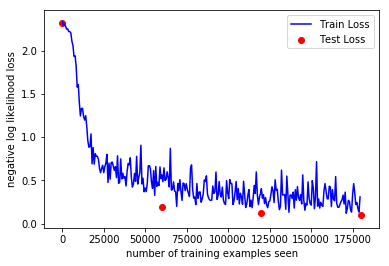

In [144]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

我们可以具体看一下识别的情况

C:\Users\xiail\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


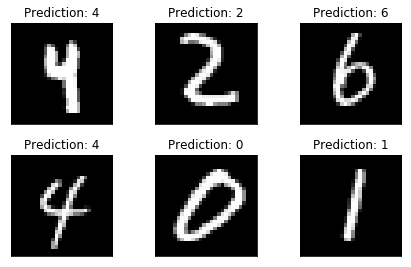

In [146]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

## 导入模型接着训练
我们还需要学会的是在已经训练好的模型上进一步优化训练，这就涉及到导入模型操作了

In [147]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [151]:
network_state_dict = torch.load('results\model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('results\optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

导入之后就可以接着训练了

In [152]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

C:\Users\xiail\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.320737
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.332131
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.299946
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.104253
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.305014
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.171680
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.329031
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.383839
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.268723
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.243837
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.266976
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.406171
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.190477
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.509731
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.273016
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.164684
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.210134
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.410940
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.412819
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.379983
Train Epoch: 4 [12800/60000 (

C:\Users\xiail\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0890, Accuracy: 9711/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.388904
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.132009
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.258141
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.392577
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.269752
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.132240
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.174920
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.441644
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.195555
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.318475
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.110979
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.189511
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.226574
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.204356
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.338259
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.250576
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.181828
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.292774
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.256771
Train Epoch: 5 [12160

Train Epoch: 8 [26880/60000 (45%)]	Loss: 0.314033
Train Epoch: 8 [27520/60000 (46%)]	Loss: 0.218844
Train Epoch: 8 [28160/60000 (47%)]	Loss: 0.203605
Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.258627
Train Epoch: 8 [29440/60000 (49%)]	Loss: 0.229536
Train Epoch: 8 [30080/60000 (50%)]	Loss: 0.172431
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.107386
Train Epoch: 8 [31360/60000 (52%)]	Loss: 0.148890
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.093513
Train Epoch: 8 [32640/60000 (54%)]	Loss: 0.139393
Train Epoch: 8 [33280/60000 (55%)]	Loss: 0.141358
Train Epoch: 8 [33920/60000 (57%)]	Loss: 0.122461
Train Epoch: 8 [34560/60000 (58%)]	Loss: 0.298906
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.288627
Train Epoch: 8 [35840/60000 (60%)]	Loss: 0.121112
Train Epoch: 8 [36480/60000 (61%)]	Loss: 0.266166
Train Epoch: 8 [37120/60000 (62%)]	Loss: 0.224871
Train Epoch: 8 [37760/60000 (63%)]	Loss: 0.103228
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.161375
Train Epoch: 8 [39040/60000 (65%)]	Loss: 0.137679


经过更多的训练之后，我们可以查看具体的训练结果，如下

C:\Users\xiail\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


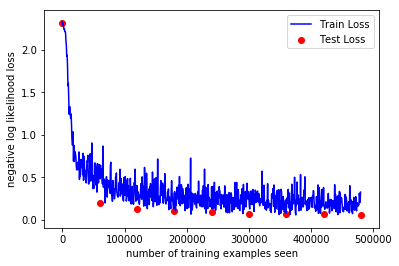

In [154]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()